In [ ]:
#!pip install protobuf==3.20
#!pip install --upgrade transformers

In [11]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Wed Sep  7 11:04:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     On   | 00000000:17:00.0 Off |                  Off |
| 33

In [12]:
from transformers import DebertaV2Tokenizer, DebertaV2TokenizerFast, DebertaTokenizerFast
from transformers import DebertaV2Config, DebertaV2Model, DebertaV2ForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
maskedlm_model = DebertaV2ForMaskedLM.from_pretrained("microsoft/deberta-v3-large")

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForMaskedLM: ['lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mode

In [5]:
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v3-large", do_lower_case=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/joan/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('coronavirus'))

['▁co', 'vid']
['▁corona', 'virus']


In [7]:
print (len(tokenizer)) 
tokenizer.add_tokens(["covid"]) 
tokenizer.add_tokens(["coronavirus"])
print (len(tokenizer)) 

128001
128003


In [8]:
print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('Covid'))
print(tokenizer.tokenize('covid'))
print(tokenizer.tokenize('coronavirus'))

['covid']
['covid']
['covid']
['coronavirus']


In [10]:
sent = "the covid and the coronavirus and COVID are bad stuff"
tokenizer.tokenize(sent)

['▁the',
 '▁',
 'covid',
 '▁and',
 '▁the',
 '▁',
 'coronavirus',
 '▁and',
 '▁',
 'covid',
 '▁are',
 '▁bad',
 '▁stuff']

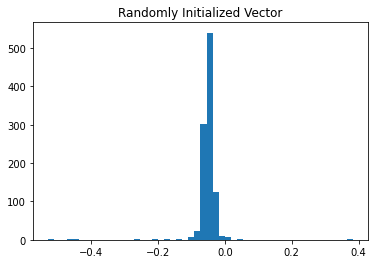

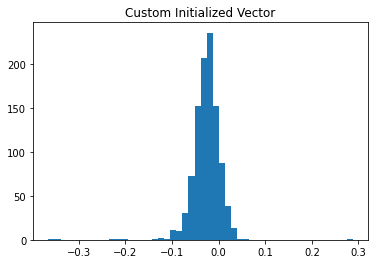

In [13]:
# FOR CORONAVIRUS:
maskedlm_model.resize_token_embeddings(len(tokenizer)) 
random_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy() # last one is covid random vector

plt.title("Randomly Initialized Vector")
plt.hist(random_vector, bins=50)
plt.show()

virus_id = tokenizer.convert_tokens_to_ids("virus")
respiratory_id = tokenizer.convert_tokens_to_ids("respiratory")
virus_embedding = maskedlm_model.get_input_embeddings().weight[virus_id]
respiratory_embedding = maskedlm_model.get_input_embeddings().weight[respiratory_id]
mean_embedding = torch.mean(torch.stack([virus_embedding, respiratory_embedding]), dim=0)
maskedlm_model.get_input_embeddings().weight[-1].data[:] = mean_embedding
mean_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Custom Initialized Vector")
plt.hist(mean_vector, bins=50)
plt.show()

# For COVID:
maskedlm_model.get_input_embeddings().weight[-2].data[:] = mean_embedding


In [ ]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="abstracts.txt",
    block_size=32,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(   
    output_dir="./",
    overwrite_output_dir=True,
    learning_rate=2e-05, 
    num_train_epochs=4,
    per_gpu_train_batch_size=32,
    save_steps=1000,
    #save_total_limit=2,
)

# Set up trainer
trainer = Trainer(
    model=maskedlm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset= dataset
)

In [11]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/home/user/miniconda3/envs/fastai/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6079
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 760


Step,Training Loss
500,4.647800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=760, training_loss=4.267692324989721, metrics={'train_runtime': 173.5935, 'train_samples_per_second': 140.074, 'train_steps_per_second': 4.378, 'total_flos': 1416909845542656.0, 'train_loss': 4.267692324989721, 'epoch': 4.0})

In [12]:
trainer.save_model("covid_trained_deberta")

Saving model checkpoint to covid_trained_deberta
Configuration saved in covid_trained_deberta/config.json
Model weights saved in covid_trained_deberta/pytorch_model.bin


In [13]:
tokenizer.save_pretrained("covid_trained_deberta_tok")

tokenizer config file saved in covid_trained_deberta_tok/tokenizer_config.json
Special tokens file saved in covid_trained_deberta_tok/special_tokens_map.json
added tokens file saved in covid_trained_deberta_tok/added_tokens.json


('covid_trained_deberta_tok/tokenizer_config.json',
 'covid_trained_deberta_tok/special_tokens_map.json',
 'covid_trained_deberta_tok/spm.model',
 'covid_trained_deberta_tok/added_tokens.json')